# TDA on Adjacency Networks

Our goal is to extract adjacency networks from shapefiles of districting data. We will then define filtration functions and filtered simplicial complexes on top of these adjacency networks. This notebook will require the TDA package `gudhi`. Instructions for installing this via `conda` can be found here: https://anaconda.org/conda-forge/gudhi

In [180]:
import geopandas

import random

import matplotlib.pyplot as plt
from functools import partial
import networkx as nx

from gerrychain import MarkovChain
from gerrychain.constraints import (
    Validator,
    single_flip_contiguous,
    within_percent_of_ideal_population,
)
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept
from gerrychain.updaters import Election, Tally, cut_edges
from gerrychain.partition import Partition
from gerrychain.proposals import recom
from gerrychain.metrics import mean_median, efficiency_gap

## Toy Example

Let's start with a basic graph to get things running (this is taken from the "GridChainSimple" notebook in this repository: https://github.com/drdeford/GerryChain-Templates).

### Creating the Graph

We will create a rectangular grid with all "rook adjacent" neighbors connected.

In [181]:
num_districts = 7
factor = 5
# The grid will be square with num_districts*factor nodes per dimension
node_size = 20
p = 0.5 # Probability voter is in group 'pin'

graph = nx.grid_graph([num_districts * factor, num_districts * factor])


for n in graph.nodes():
    graph.node[n]["population"] = 1

    if random.random() < p:
        graph.node[n]["pink"] = 1
        graph.node[n]["purple"] = 0
    else:
        graph.node[n]["pink"] = 0
        graph.node[n]["purple"] = 1
    if 0 in n or num_districts * factor - 1 in n:
        graph.node[n]["boundary_node"] = True
        graph.node[n]["boundary_perim"] = 1

    else:
        graph.node[n]["boundary_node"] = False

Create a districting plan. We just cut the grid into columns of width 'factor' to start.

In [182]:
cddict = {x: int(x[0] / factor) for x in graph.nodes()}

### Plot grids

Now we use `neworkx` functions to plot our graph. In particular, we plot:

- Basic grid graph
- Grid graph with voter labels
- Grid graph with districts drawn in

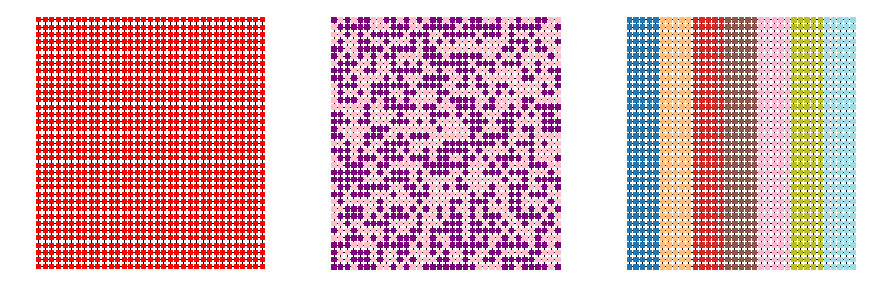

In [183]:
fig = plt.figure(figsize = (15,5))

# Plot the basic graph
fig.add_subplot(1,3,1)
nx.draw(graph, pos={x: x for x in graph.nodes()}, node_size=node_size, node_shape="s")

# Plot the graph with voter labels
cdict = {1: "pink", 0: "purple"}

fig.add_subplot(1,3,2)
nx.draw(
    graph,
    pos={x: x for x in graph.nodes()},
    node_color=[cdict[graph.node[x]["pink"]] for x in graph.nodes()],
    node_size=node_size,
    node_shape="s",
)


# Plot the graph with district labels
fig.add_subplot(1,3,3)
nx.draw(
    graph,
    pos={x: x for x in graph.nodes()},
    node_color=[cddict[x] for x in graph.nodes()],
    node_size=node_size,
    node_shape="s",
    cmap="tab20",
)

### Run a Markov Chain

Now we'll take our basic districting plan as a seed and run the Markov chain on it to produce a random district. This is done using the `gerrychain` package with the following steps.

#### Define Updaters

The `updaters` keep track of geometric and demographic features at each step.

In [184]:
def step_num(partition):
    parent = partition.parent
    if not parent:
        return 0
    return parent["step_num"] + 1


updaters = {
    "population": Tally("population"),
    "cut_edges": cut_edges,
    "step_num": step_num,
    "Pink-Purple": Election("Pink-Purple", {"Pink": "pink", "Purple": "purple"}),
}

#### Build Partition

`Partition` class keeping track of the underlying graph, the district reassignment at each step and all of the `updaters` information at each step.

In [185]:
grid_partition = Partition(graph, assignment=cddict, updaters=updaters)

#### Constraints

Put constraints on the Markov chain updates. Here we declare that the population in each district has to be within `percentage` percent of the ideal (equal population in every district).

In [186]:
percentage = 0.1
popbound = within_percent_of_ideal_population(grid_partition, percentage)

#### Proposal function

We use the proposal function to define new partitions at each step. It will enforce our constraint at each step.

In [187]:
# The ideal population is to have an equal number of voters per district
ideal_population = sum(grid_partition["population"].values()) / len(grid_partition)

tree_proposal = partial(
    recom,
    pop_col="population",
    pop_target=ideal_population,
    epsilon=0.05,
    node_repeats=1,
)

#### Create the Markov Chain Class

We'll use the `recom_chain` method via `tree_proposal` defined above. Change the number of steps here to allow more mixing.

In [188]:
recom_chain = MarkovChain(
    tree_proposal,
    Validator([popbound]),
    accept=always_accept,
    initial_state=grid_partition,
    total_steps=40,
)

#### Run the Markov Chain

This will keep track of the various statistics at each step in the walk. We run the walk then plot the resulting districting plus plots of the various statistics.

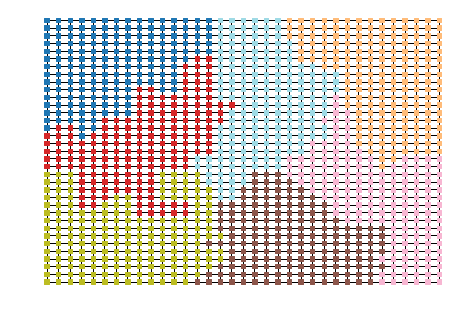

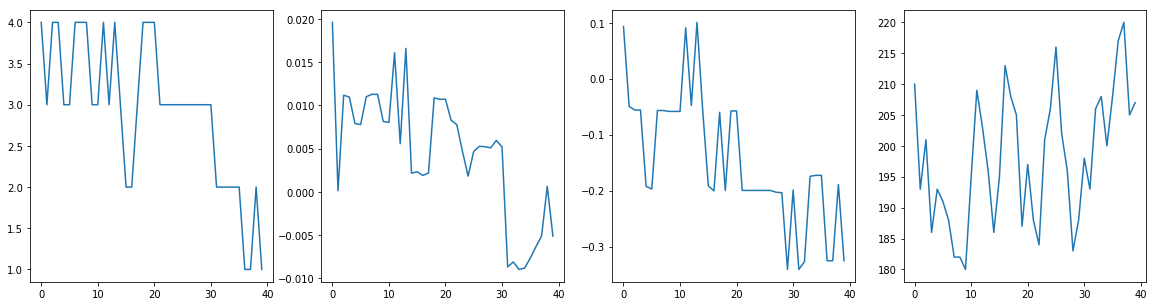

In [10]:
rsw = [] # Number of district won by 'Pink' voters
rmm = [] 
reg = [] # Efficiency gap
rce = []

for part in recom_chain:
    rsw.append(part["Pink-Purple"].wins("Pink"))
    rmm.append(mean_median(part["Pink-Purple"]))
    reg.append(efficiency_gap(part["Pink-Purple"]))
    rce.append(len(part["cut_edges"]))

plt.figure()
nx.draw(
    graph,
    pos={x: x for x in graph.nodes()},
    node_color=[dict(part.assignment)[x] for x in graph.nodes()],
    node_size=node_size,
    node_shape="s",
    cmap="tab20",
);

fig = plt.figure(figsize=(20,5))

fig.add_subplot(1,4,1)
plt.plot(rsw);

fig.add_subplot(1,4,2)
plt.plot(rmm);

fig.add_subplot(1,4,3)
plt.plot(reg);

fig.add_subplot(1,4,4)
plt.plot(rce);

### Adjacency Network

Now let's get the adjacency network for our new districting. We will have a node for each district. Nodes are connected in the adjacency matrix if they are connected by a cut edge. 

We first define a function to extract the district pairs (based on presence of a cut edge between them) from a partition.

In [11]:
def district_pairs(part):
    pairs = []
    for x, y in part['cut_edges']:
        pairs.append((part.assignment[x],part.assignment[y]))
    return set(pairs)

Now we define a function which takes a partition and produces an adjacency graph.

In [12]:
def adjacency_graph_cut_edges(part):
    edges = district_pairs(part)
    adjacency_graph = nx.Graph()
    adjacency_graph.add_nodes_from(list({x for (x,y) in edges}))
    adjacency_graph.add_edges_from(list(edges))
    return adjacency_graph

Let's draw the results to see if they make sense.

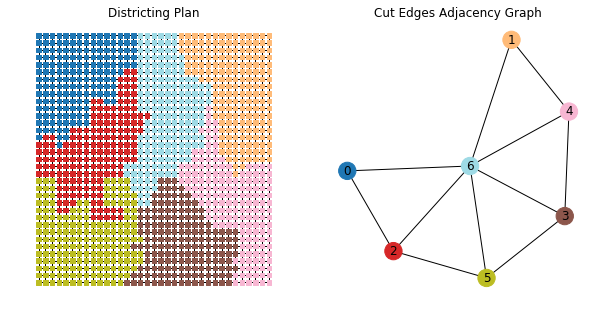

In [13]:
fig = plt.figure(figsize = (10,5))

fig.add_subplot(1,2,1)

nx.draw(
    graph,
    pos={x: x for x in graph.nodes()},
    node_color=[dict(part.assignment)[x] for x in graph.nodes()],
    node_size=node_size,
    node_shape="s",
    cmap="tab20",
);

plt.title('Districting Plan');

fig.add_subplot(1,2,2)
nx.draw_networkx(adjacency_graph_cut_edges(part), 
                 node_color = [x for x in adjacency_graph_cut_edges(part).nodes()], 
                 cmap="tab20")
plt.title('Cut Edges Adjacency Graph');
plt.axis('off');

### Filtration Function

We will also want to keep track of various numbers which we think of as weights on the vertices or edges. For example, we could keep track of the 'Pink' voting percentage in each district.

In [14]:
pink_voter_share = part["Pink-Purple"].percents("Pink")

In [15]:
pink_voter_share

(0.47904191616766467,
 0.5240641711229946,
 0.49707602339181284,
 0.46745562130177515,
 0.47904191616766467,
 0.4891304347826087,
 0.48333333333333334)

## Defining a Filtration on the Adjacency Graph

Now let's import some software to do topological data analysis on the adjacency graph. The TDA software we will use here is the `gudhi` package. The package is quite flexible in that it allows us to define custom filtrations on a simplicial complex.

In [16]:
import numpy as np
import gudhi as gd

Let's fix an adjacency graph to run the computations on.

In [17]:
adjacency_graph = adjacency_graph_cut_edges(part)

### Simplex Tree

We first turn the adjacency graph into a simplicial complex. In `gudhi`, a simplicial complex is represented as a datatype called a `SimplexTree`. It is simply an efficient way to store a simplicial complex, introduced here: https://link.springer.com/article/10.1007/s00453-014-9887-3

To create a simplicial complex from our adjacency graph, we start with an 'empty simplicial complex', then add in the edges. Vertices will be added automatically, so that we are really describing an honest simplicial complex.

In [18]:
# Initialize with an empty simplex tree
spCpx = gd.SimplexTree()

# Add edges from the adjacency graph
for edge in adjacency_graph.edges:
    spCpx.insert(list(edge))

We can list the simplices in our complex as follows.

In [19]:
spCpx_list = spCpx.get_filtration() 

for splx in spCpx_list :
    print(splx)

([0], 0.0)
([1], 0.0)
([2], 0.0)
([0, 2], 0.0)
([3], 0.0)
([4], 0.0)
([1, 4], 0.0)
([3, 4], 0.0)
([5], 0.0)
([2, 5], 0.0)
([3, 5], 0.0)
([6], 0.0)
([0, 6], 0.0)
([1, 6], 0.0)
([2, 6], 0.0)
([3, 6], 0.0)
([4, 6], 0.0)
([5, 6], 0.0)


Pause for a second here to understand this output.

Note the number `0.0` assigned to each simplex. This is the *filtration value*, thinking of our object as a *filtered simplicial complex*. We can change these filtration values as follows. We will use `pink_voter_share` as our filtration function on the vertices --- one thing that's great about the `gudhi` packages is that it allows us to use any filtration function we want.

We start by adding the appropriate filtration value to each vertex of the simplicial complex.

In [20]:
zero_skeleton = spCpx.get_skeleton(0)

for j in range(len(zero_skeleton)):
    spCpx.assign_filtration(zero_skeleton[j][0], filtration=pink_voter_share[j])
    
spCpx_list = spCpx.get_filtration() 
for splx in spCpx_list:
    print(splx)   

([0, 2], 0.0)
([1, 4], 0.0)
([3, 4], 0.0)
([2, 5], 0.0)
([3, 5], 0.0)
([0, 6], 0.0)
([1, 6], 0.0)
([2, 6], 0.0)
([3, 6], 0.0)
([4, 6], 0.0)
([5, 6], 0.0)
([3], 0.46745562130177515)
([0], 0.47904191616766467)
([4], 0.47904191616766467)
([6], 0.48333333333333334)
([5], 0.4891304347826087)
([2], 0.49707602339181284)
([1], 0.5240641711229946)


We can plot the adjacency network with nodes colored by their filtration values.

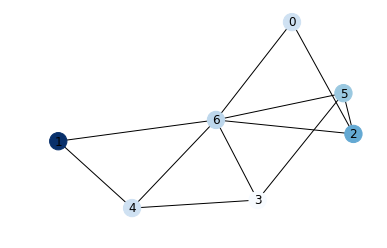

In [21]:
nx.draw_networkx(adjacency_graph, node_color=pink_voter_share, cmap=plt.cm.Blues)
plt.axis('off');

Assigning the function only on the vertices doesn't produce a valid filtered simplicial complex: edges arrive earlier in the filtration than their endpoints! There is a function to fix this called `make_filtration_non_decreasing`.

In [22]:
spCpx.make_filtration_non_decreasing()
spCpx_list = spCpx.get_filtration()
for splx in spCpx_list:
    print(splx) 

([3], 0.46745562130177515)
([0], 0.47904191616766467)
([4], 0.47904191616766467)
([3, 4], 0.47904191616766467)
([6], 0.48333333333333334)
([0, 6], 0.48333333333333334)
([3, 6], 0.48333333333333334)
([4, 6], 0.48333333333333334)
([5], 0.4891304347826087)
([3, 5], 0.4891304347826087)
([5, 6], 0.4891304347826087)
([2], 0.49707602339181284)
([0, 2], 0.49707602339181284)
([2, 5], 0.49707602339181284)
([2, 6], 0.49707602339181284)
([1], 0.5240641711229946)
([1, 4], 0.5240641711229946)
([1, 6], 0.5240641711229946)


Now we have a filtered simplicial complex, to which we can apply persistent homology. Here we are computing the $0$-dimensional persistent homology. That is, we are looking at persistent *connected components* in the simplicial complex.

In [23]:
BarCodes = spCpx.persistence()
BarCodes

[(0, (0.46745562130177515, inf)),
 (0, (0.47904191616766467, 0.48333333333333334))]

We can plot a barcode or a persistence diagram from our persistent homology computation.

#### Disclaimer:

This data is randomized, so when you run it you might get a single bar in your barcode. In this case, the persistence diagram plot might look weird!

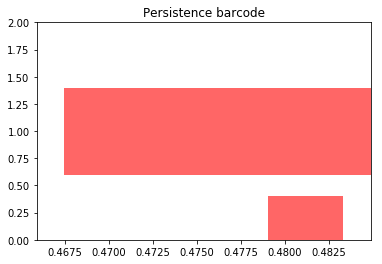

In [24]:
gd.plot_persistence_barcode(BarCodes);

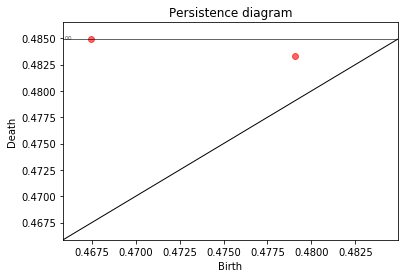

In [25]:
gd.plot_persistence_diagram(BarCodes);

#### Exercise

Compare these plots with the plot of the adjacency network with filtration values. Stare at these outputs until they make sense.

Try running everything again with a different random districting plan. You can play with parameters to produce more districts and get more complicated adjacency graphs or a different voter distribution.

## Working with Real Districting Data

### Importing and Creating Data

Now we will import some real districting plans for Pennsylvania and create some plans via the tree recombination algorithm. The first part of the code is from the `Day1` section in this repository: https://github.com/vrdi/GerryChain-BootCamp

In [26]:
import csv
import os
from functools import partial
import json
import networkx as nx

import geopandas as gpd
import matplotlib.pyplot as plt

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import efficiency_gap, mean_median
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

In [27]:
newdir = "./Outputs/"
os.makedirs(os.path.dirname(newdir + "init.txt"), exist_ok=True)
with open(newdir + "init.txt", "w") as f:
    f.write("Created Folder")


graph_path = "./Data/PA_VTDALL.json"  # "./Data/PA_BPOP_FINAL/VTD_FINAL.shp"
plot_path = "./Data/VTD_FINAL.shp"

Import some data.

In [28]:
df = gpd.read_file(plot_path)


unique_label = "GEOID10"
pop_col = "TOT_POP"
district_col = "2011_PLA_1"
county_col = "COUNTYFP10"

num_elections = 3


election_names = [
    "PRES12",
    "PRES16",
    "SENW101216",
]
election_columns = [
    ["PRES12D", "PRES12R"],
    ["T16PRESD", "T16PRESR"],
    ["W101216D", "W101216R"],
]


graph = Graph.from_json(graph_path)

Define updaters.

In [29]:
updaters = {
    "population": updaters.Tally("TOT_POP", alias="population"),
    "cut_edges": cut_edges,
}

elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(num_elections)
]

election_updaters = {election.name: election for election in elections}

updaters.update(election_updaters)

We will look at some 'premade' partitions. In particular, `partition_2011` is the real districting plan from 2011.

In [30]:
partition_2011 = Partition(graph, "2011_PLA_1", updaters)
partition_GOV = Partition(graph, "GOV", updaters)
partition_TS = Partition(graph, "TS", updaters)
partition_REMEDIAL = Partition(graph, "REMEDIAL_P", updaters)
partition_CPCT = Partition(graph, "538CPCT__1", updaters)
partition_DEM = Partition(graph, "538DEM_PL", updaters)
partition_GOP = Partition(graph, "538GOP_PL", updaters)
partition_8th = Partition(graph, "8THGRADE_1", updaters)

Now we define 5 random plans by making cuts according to the spanning tree.

In [31]:
tree_partitions = []

tree_plans = 5
n_base_plans = 8

for i in range(tree_plans):
    print('Finished tree plan', i)
    cddict = recursive_tree_part(graph, range(18), df["TOT_POP"].sum() / 18, "TOT_POP", .01, 1)
    tree_partitions.append(Partition(graph, cddict, updaters))

partition_list = [partition_2011, partition_GOV, partition_TS,
                  partition_REMEDIAL, partition_CPCT, partition_DEM,
                  partition_GOP, partition_8th]

partition_list = partition_list + tree_partitions

n_plans = tree_plans + n_base_plans

Finished tree plan 0
Finished tree plan 1
Finished tree plan 2
Finished tree plan 3
Finished tree plan 4


In [32]:
def cut_edges_metric(part):
    return len(part["cut_edges"])


print("The 2011 plan has", cut_edges_metric(partition_2011) , "cut edges.")
print("The GOV plan has", cut_edges_metric(partition_GOV), "cut edges.")
print("The TS plan has", cut_edges_metric(partition_TS), "cut edges.")
print("The REMEDIAL plan has", cut_edges_metric(partition_REMEDIAL), "cut edges.")
print("The 538 Compact plan has", cut_edges_metric(partition_CPCT), "cut edges.")
print("The 538 DEM plan has", cut_edges_metric(partition_DEM), "cut edges.")
print("The 538 GOP plan has", cut_edges_metric(partition_GOP), "cut edges.")
print("The 8th grade plan has", cut_edges_metric(partition_8th), "cut edges.")

for i in range(tree_plans):
    print("Tree plan", i + 1, "cut edges:" , cut_edges_metric(tree_partitions[i]))

The 2011 plan has 2361 cut edges.
The GOV plan has 1418 cut edges.
The TS plan has 1556 cut edges.
The REMEDIAL plan has 1402 cut edges.
The 538 Compact plan has 1176 cut edges.
The 538 DEM plan has 1776 cut edges.
The 538 GOP plan has 1543 cut edges.
The 8th grade plan has 1433 cut edges.
Tree plan 1 cut edges: 1791
Tree plan 2 cut edges: 1861
Tree plan 3 cut edges: 1794
Tree plan 4 cut edges: 1824
Tree plan 5 cut edges: 1717


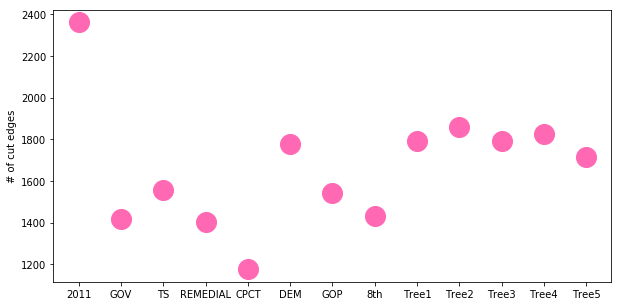

In [33]:
plt.figure(figsize = (10,5))

ys = [cut_edges_metric(part) for part in partition_list]

plt.plot(ys, 'o', color='hotpink', markersize=20);

plt.ylabel("# of cut edges");

labels = ['2011', 'GOV', 'TS', 'REMEDIAL', 'CPCT', 'DEM', 'GOP', '8th'] + ["Tree" + str(k + 1) for k in range(tree_plans)];

plt.xticks(range(len(labels)), labels);

### TDA on the Adjacency Networks

Now we can:

- Create adjacency networks for each partition
- Filter by Democratic voter share (or any other function of the district demographics that we find interesting)
- Compute persistent homology and persistence diagrams

Do the results have any interesting interpretations? 

#### Disclaimer

`gudhi` might give some warnings if your persistence diagrams consist of only a single point. This is not anything to worry about.

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


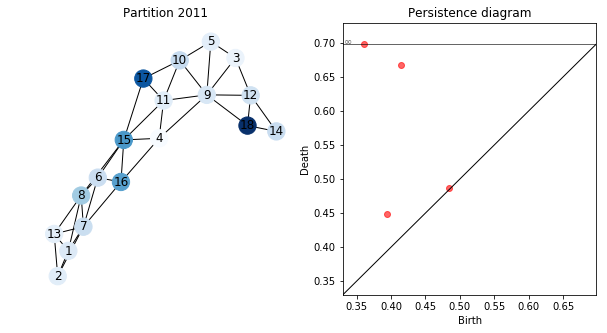

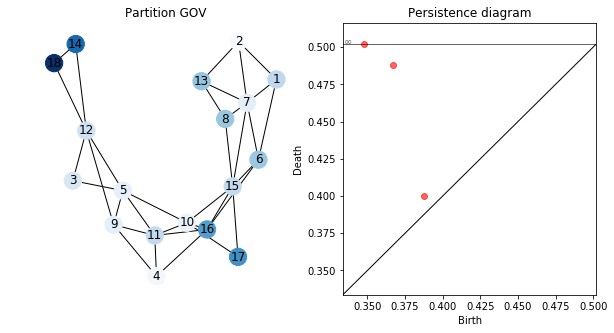

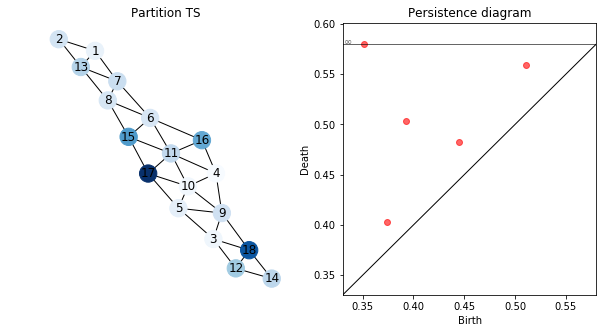

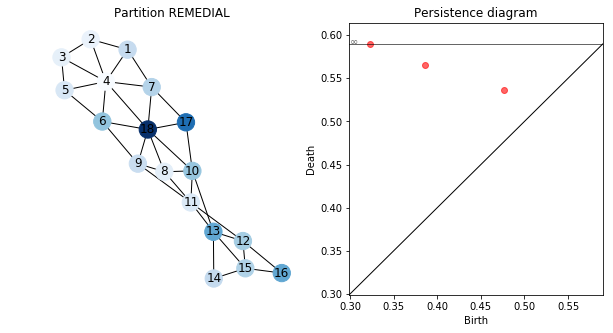

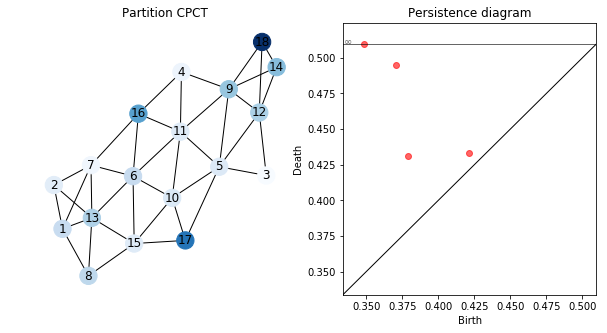

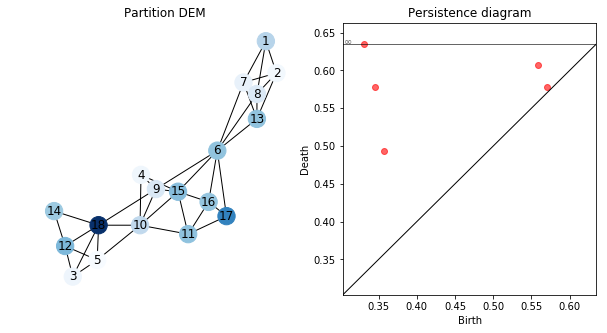

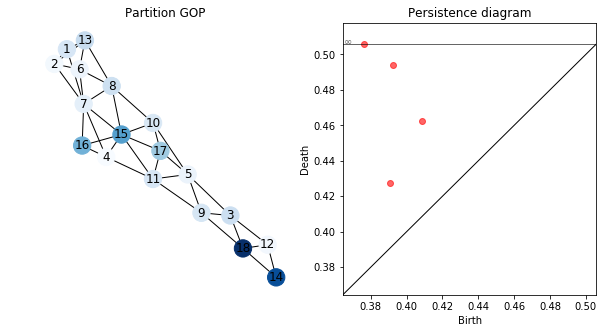

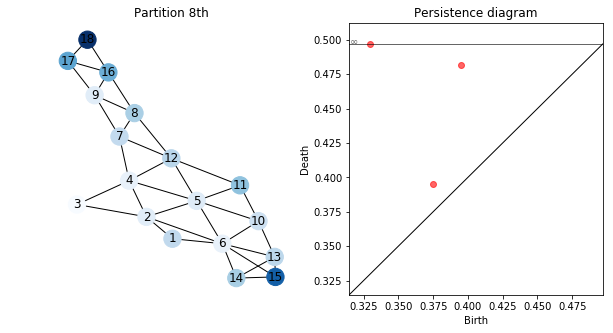

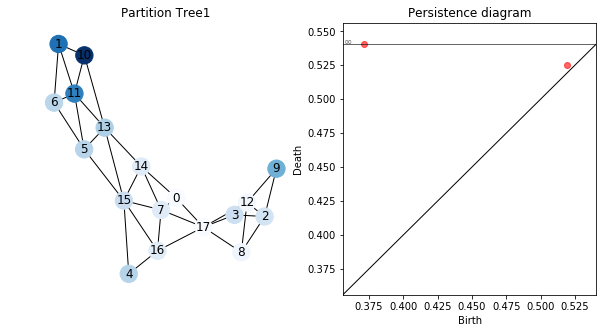

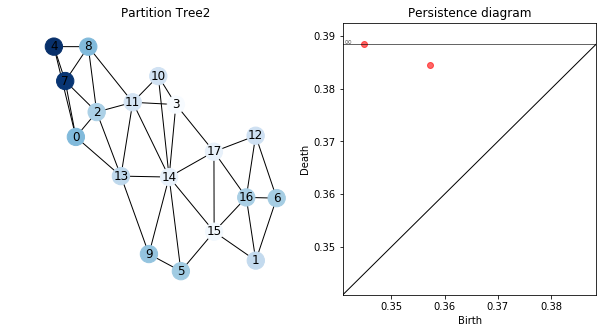

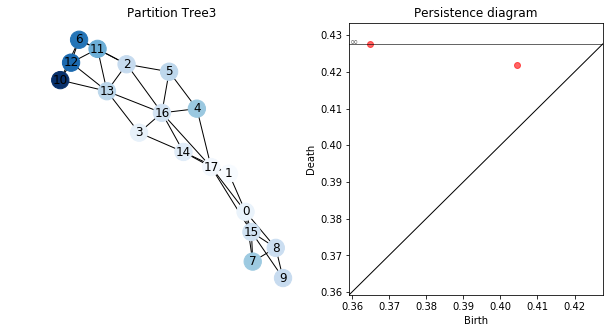

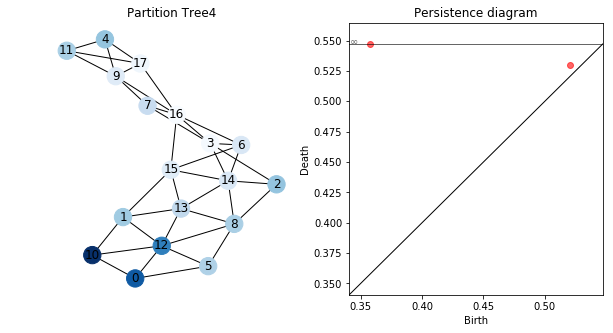

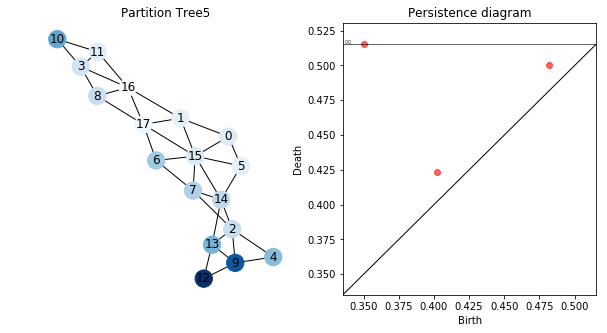

In [177]:
for k in range(13):
    part = partition_list[k]

    adjacency_graph = adjacency_graph_cut_edges(part)

    spCpx = gd.SimplexTree()
    for edge in adjacency_graph.edges:
        spCpx.insert(list(edge))

    Democratic_voter_share = part['PRES12'].percents('Democratic')

    zero_skeleton = spCpx.get_skeleton(0)

    for j in range(len(zero_skeleton)):
        spCpx.assign_filtration(zero_skeleton[j][0], filtration=Democratic_voter_share[j])

    spCpx.make_filtration_non_decreasing()

    BarCodes = spCpx.persistence()

    fig = plt.figure(figsize = (10,5))

    ax = fig.add_subplot(1,2,1)
    nx.draw_networkx(adjacency_graph, node_color=Democratic_voter_share, cmap=plt.cm.Blues)
    plt.title('Partition '+labels[k])
    ax.axis('off')

    fig.add_subplot(1,2,2)
    gd.plot_persistence_diagram(BarCodes);

#### Exercise

Study the output filtered adjacency networks and persistence diagrams. Do you notice any qualitative trends?

### Bottleneck Distance Between the Adjacency Networks

Now let's compare these persistence diagrams more quantitatively. First we store the simplicial complexes in a list.

In [174]:
partitions_spCpx = []

for k in range(13):
    part = partition_list[k]

    adjacency_graph = adjacency_graph_cut_edges(part)

    spCpx = gd.SimplexTree()
    for edge in adjacency_graph.edges:
        spCpx.insert(list(edge))
    
    Democratic_voter_share = part['PRES12'].percents('Democratic')
    
    zero_skeleton = spCpx.get_skeleton(0)

    for j in range(len(zero_skeleton)):
        spCpx.assign_filtration(zero_skeleton[j][0], filtration=Democratic_voter_share[j])

    spCpx.make_filtration_non_decreasing()

    partitions_spCpx.append(spCpx)

Now we can create a distance matrix containing the bottleneck distance between any pair of barcodes.

In [175]:
distMat = np.zeros((13,13))

for j in range(13):
    for k in range(13):
        spCpx0 = partitions_spCpx[j]
        spCpx1 = partitions_spCpx[k]
        
        spCpx0.persistence()
        spCpx1.persistence()

        I0 = spCpx0.persistence_intervals_in_dimension(0)
        I1 = spCpx1.persistence_intervals_in_dimension(0)

        distMat[j,k] = gd.bottleneck_distance(I0,I1)

We view the distance matrix as an image.

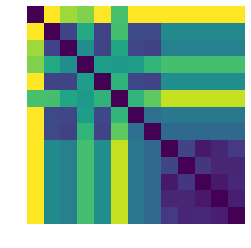

In [176]:
plt.imshow(distMat);
plt.axis('off');

To understand the shape of the 'space of districting plans', we can use Multi-Dimensional Scaling. This algorithm looks for the set of points in $\mathbb{R}^2$ (or $\mathbb{R}^3$) whose distance matrix is as close as possible to the distance matrix we just computed. For a more precise description, go here: https://en.wikipedia.org/wiki/Multidimensional_scaling

The result gives us a visualization of how similar the districting plans are.

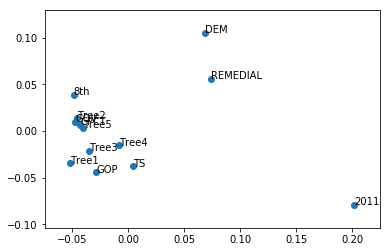

In [169]:
# Import a package containing the MDS algorithm and set options for the algorithm
from sklearn import manifold
mds = manifold.MDS(n_components=2, dissimilarity="precomputed")

# Compute MDS and extract the coordinates of the points
results = mds.fit(distMat)
coords = results.embedding_

z = coords[:,0]
y = coords[:,1]

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(labels):
    ax.annotate(txt, (z[i], y[i]))

We can also use MDS to project the data to 3D. It takes a little more work to make the plot. You can try running this a few times; MDS doesn't have a unique answer and the algorithm involves some randomness, so you will get something different every time you run it.

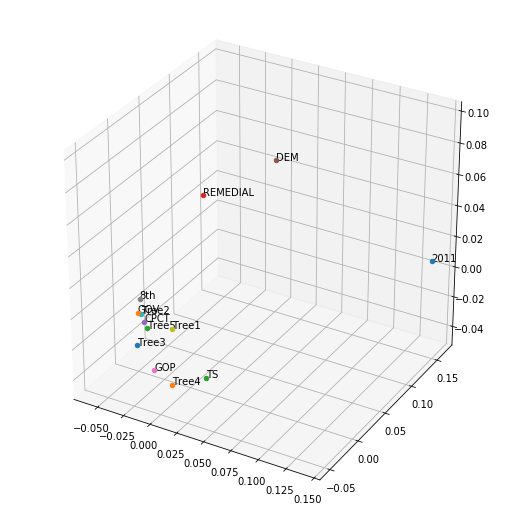

In [173]:
from mpl_toolkits.mplot3d import Axes3D

mds = manifold.MDS(n_components=3, dissimilarity="precomputed")
results = mds.fit(distMat)
coords = results.embedding_

fig = plt.figure(figsize = (7,7))
ax = Axes3D(fig)

for i, txt in enumerate(labels):
    ax.scatter(coords[i,0],coords[i,1],coords[i,2]) 
    ax.text(coords[i,0],coords[i,1],coords[i,2],  '%s' % (txt), size=10, zorder=1) 


pyplot.show()

#### Exercise

What does this figure suggest to you about the districting plans?

#### Exercise

Try other stuff! Here are some ideas:

- Define other filtration functions on the networks and rerun the above computations. You could also filter by other demographic information, use the Feng-Porter filtration function, use weighted sums of functions etc.
- Specifically, try filtering by Republican voter share. Do you get anything much different in the MDS plots? Should you expect to?
- Define a metric on the adjacency network and use the Vietoris-Rips to filter it. This functionality is built into `gudhi`, but you will have to dig through the documentation a bit to figure out how to do it: http://gudhi.gforge.inria.fr/ripscomplex/
- Run similar experiments on districting plans for other states.
- Pick a couple of different seeds, run Markov chains to generate Markov chains with these seeds. Do the plans coming from the different seeds stay near their seeds (measured via bottleneck distance for their adjacency networks)? This could give a picture of the mixing behavior of this Markov chain. 
- Generalize this to run on more complicated adjacency networks, such as those that were considered in Feng-Porter.